## Calling iSNVs from a sample with a known reference sequence using two replicates.


We will use paired reads from two samples in the data/ folder. These were sequenced from invitro samples. 
Let's start by aligning these reads to PRV.fa present in the db/ folder. The first step is creating an index to align the reads to. 

In [2]:
%%bash
bwa index db/PRV.fa

[bwa_index] Pack FASTA... 0.00 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 0.00 seconds elapse.
[bwa_index] Update BWT... 0.00 sec
[bwa_index] Pack forward-only FASTA... 0.00 sec
[bwa_index] Construct SA from BWT and Occ... 0.00 sec
[main] Version: 0.7.17-r1194-dirty
[main] CMD: bwa index db/PRV.fa
[main] Real time: 0.007 sec; CPU: 0.008 sec


In [3]:
%%bash
bwa mem -t 32 db/PRV.fa data/ZI-52_a_R1.subsampled.fastq.gz data/ZI-52_a_R2.subsampled.fastq.gz | samtools view -b -F 4 -F 2048 | samtools sort -o Z52_a.sorted.bam   
bwa mem -t 32 db/PRV.fa data/ZI-52_b_R1.subsampled.fastq.gz data/ZI-52_b_R2.subsampled.fastq.gz | samtools view -b -F 4 -F 2048 | samtools sort -o Z52_b.sorted.bam   


[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 651764 sequences (163592764 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (648, 301882, 1824, 756)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (1783, 3040, 5355)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 12499)
[M::mem_pestat] mean and std.dev: (3447.54, 1974.79)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 16071)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (450, 466, 476)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (398, 528)
[M::mem_pestat] mean and std.dev: (461.30, 17.01)
[M::mem_pestat] low and high boundaries for proper pairs: (372, 554)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (135, 154, 1348)
[M::mem_pes

Let's now trim off the primer sequences using ivar. In order to do this we need three files.

1. BED file with primer coordinates. We will generate this by aligning the primer sequences to the reference sequence and then using [bedtools](https://bedtools.readthedocs.io/en/latest/) to create the BED file.
2. Aligned and sorted BAM file generate in the previous step.

The primers are present in a fasta file in db/zika_primers.fa. Note that we change the minimum threshold for the alignment score and the seed length to 5 for bwa. 

In [4]:
%%bash
bwa mem -k 5 -T 16 db/PRV.fa db/zika_primers.fa | samtools view -b -F 4 > db/zika_primers.bam
bedtools bamtobed -i db/zika_primers.bam > db/zika_primers.bed

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 70 sequences (1542 bp)...
[M::mem_process_seqs] Processed 70 reads in 0.005 CPU sec, 0.005 real sec
[main] Version: 0.7.17-r1194-dirty
[main] CMD: bwa mem -k 5 -T 16 db/PRV.fa db/zika_primers.fa
[main] Real time: 0.007 sec; CPU: 0.010 sec


We will now use this BED file as input to ivar to trim primer sequences. 
Note that this BED file has to be generated only once for a reference sequence.

In [5]:
%%bash
ivar trim -b db/zika_primers.bed -p Z52_a.trimmed -i Z52_a.sorted.bam
ivar trim -b db/zika_primers.bed -p Z52_b.trimmed -i Z52_b.sorted.bam

# Sort and index trimmed BAM file.
samtools sort -o Z52_a.trimmed.sorted.bam Z52_a.trimmed.bam
samtools index Z52_a.trimmed.sorted.bam

samtools sort -o Z52_b.trimmed.sorted.bam Z52_b.trimmed.bam
samtools index Z52_b.trimmed.sorted.bam

Number of references: 1
Reference Name: PRV
Reference Length: 10807
Using Region: PRV
Sorted By Coordinate
Sorted By Query Name
Results: 
Trimmed primers from 644979 reads.
69219 reads were shortened below the minimum length of 30 bp and were not writen to file.
5855 reads that started outside of primer regions were not written to file.
Number of references: 1
Reference Name: PRV
Reference Length: 10807
Using Region: PRV
Sorted By Coordinate
Sorted By Query Name
Results: 
Trimmed primers from 810358 reads.
88434 reads were shortened below the minimum length of 30 bp and were not writen to file.
7686 reads that started outside of primer regions were not written to file.


[W::hts_idx_load2] The index file is older than the data file: Z52_a.sorted.bam.bai
[W::hts_idx_load2] The index file is older than the data file: Z52_b.sorted.bam.bai


Let's quicky take a look at the depth of the trimmed vs untrimmed BAM file. We'll extract the depth using the `samtools depth` command.

In [8]:
%%bash
samtools depth -a Z52_a.trimmed.sorted.bam Z52_b.trimmed.sorted.bam > Z52.trimmed.sorted.depth
samtools depth -a Z52_a.sorted.bam Z52_b.sorted.bam > Z52.sorted.depth

Now let's plot the depth per position.

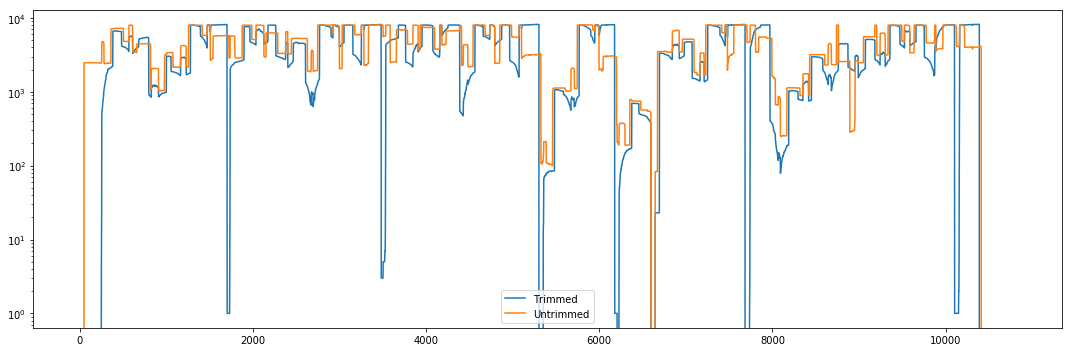

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

df_trimmed = pd.read_table("Z52.trimmed.sorted.depth", sep = "\t", names = ["Ref", "Pos", "depth_a", "depth_b"])
df_untrimmed = pd.read_table("Z52.sorted.depth", sep = "\t", names = ["Ref", "Pos", "depth_a", "depth_b"])

ax = df_trimmed["depth_a"].plot(logy=True, label = "Trimmed", figsize = (15,5))
df_untrimmed["depth_a"].plot(logy=True, ax = ax, label ="Untrimmed")
plt.legend()
plt.tight_layout()
plt.show()

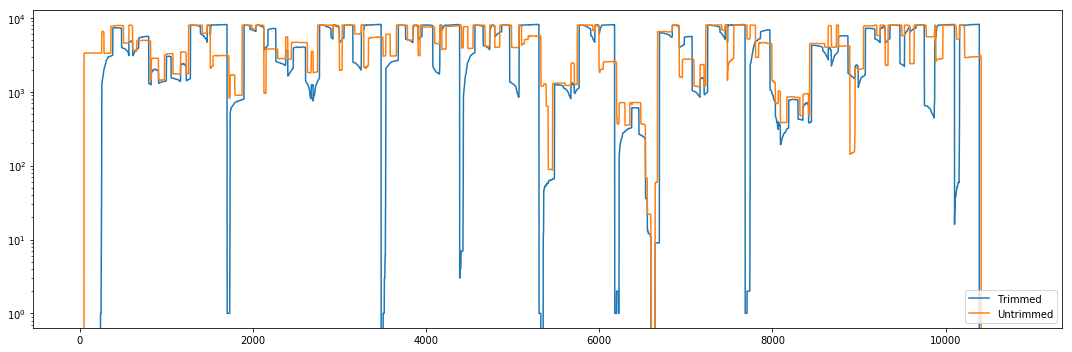

In [10]:
plt.clf()
ax = df_trimmed["depth_b"].plot(logy=True, label = "Trimmed", figsize = (15,5))
df_untrimmed["depth_b"].plot(logy=True, ax = ax, label ="Untrimmed")
plt.legend()
plt.tight_layout()
plt.show()

Now we need to identify primer sequences that might have a mismatch with the consensus sequence to ensure that we remove reads from any amplicon that might bias the iSNV frequency due to varying primer binding effeciency. 

To do this, we do this following steps,

1. Merge the two replicates A and B.
2. Call consensus on merged BAM file.
3. Align primer sequences to consensus after creating a bwa index from the consensus sequence called.

In [35]:
%%bash
# If you are re-running this step, you might have to delete the Z52.merged.bam file or specify a -f option to overwrite an existing BAM
samtools merge Z52.merged.bam Z52_a.trimmed.sorted.bam Z52_b.trimmed.sorted.bam
samtools mpileup -A -d 0 -Q 0 Z52.merged.bam | ivar consensus -p Z52.consensus
bwa index -p db/Z52.consensus Z52.consensus.fa
bwa mem -k 5 -T 16 db/Z52.consensus db/zika_primers.fa | samtools view -bS -F 4 | samtools sort -o db/zika_primers_consensus.bam

Minimum Quality: 20
Threshold: 0
Minimum depth: 0
Regions with depth less than minimum depth covered by: -


[bam_merge] File 'Z52.merged.bam' exists. Please apply '-f' to overwrite. Abort.
[mpileup] 1 samples in 1 input files
[mpileup] Max depth set to maximum value (2147483647)
[bwa_index] Pack FASTA... 0.00 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 0.00 seconds elapse.
[bwa_index] Update BWT... 0.00 sec
[bwa_index] Pack forward-only FASTA... 0.00 sec
[bwa_index] Construct SA from BWT and Occ... 0.00 sec
[main] Version: 0.7.17-r1194-dirty
[main] CMD: bwa index -p db/Z52.consensus Z52.consensus.fa
[main] Real time: 0.007 sec; CPU: 0.008 sec
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 70 sequences (1542 bp)...
[M::mem_process_seqs] Processed 70 reads in 0.005 CPU sec, 0.005 real sec
[main] Version: 0.7.17-r1194-dirty
[main] CMD: bwa mem -k 5 -T 16 db/Z52.consensus db/zika_primers.fa
[main] Real time: 0.006 sec; CPU: 0.009 sec


Let's now call iSNVs on this BAM file at a minimum threshold of 3% and the default minimum quality threshold of 20.

In [36]:
%%bash
samtools mpileup -A -d 0 --reference Z52.consensus.fa -Q 0 db/zika_primers_consensus.bam | ivar variants -p primers_Z52_consensus -t 0.03

[mpileup] 1 samples in 1 input files
[mpileup] Max depth set to maximum value (2147483647)


Let's now get the indices of primers with mismtaches and their respective pairs. 
To get the pair information, we need a tsv file with two columns to represent the pairs of primers.
This file is at db/pair_information.tsv

In [24]:
%%bash
bedtools bamtobed -i db/zika_primers_consensus.bam > db/zika_primers_consensus.bed

In [26]:
%%bash
ivar getmasked -i primers_Z52_consensus.tsv -b db/zika_primers_consensus.bed -f db/pair_information.tsv -p primer_mismatchers_indices


Primer pair for 400_1_out_R not found in BED file.
Primer pair for 400_35_out_L not found in BED file.
400_18_out_L**	400_18_out_R**	400_23_out_R	400_23_out_L	400_32_out_L	400_32_out_R


In [27]:
%%bash
ivar removereads -i Z52_a.trimmed.sorted.bam -p Z52_a.masked.bam -t primer_mismatchers_indices.txt -b db/zika_primers.bed
ivar removereads -i Z52_b.trimmed.sorted.bam -p Z52_b.masked.bam -t primer_mismatchers_indices.txt -b db/zika_primers.bed

Writing to Z52_a.masked.bam
Number of references: 1
Reference Name: PRV
Reference Length: 10807
Using Region: PRV
Sorted By Coordinate
Results:
16890 reads were removed.
Writing to Z52_b.masked.bam
Number of references: 1
Reference Name: PRV
Reference Length: 10807
Using Region: PRV
Sorted By Coordinate
Results:
28853 reads were removed.


In [28]:
%%bash
samtools sort -o Z52_a.masked.sorted.bam Z52_a.masked.bam
samtools sort -o Z52_b.masked.sorted.bam Z52_b.masked.bam

samtools depth -a Z52_a.masked.sorted.bam Z52_b.masked.sorted.bam > Z52.masked.sorted.depth

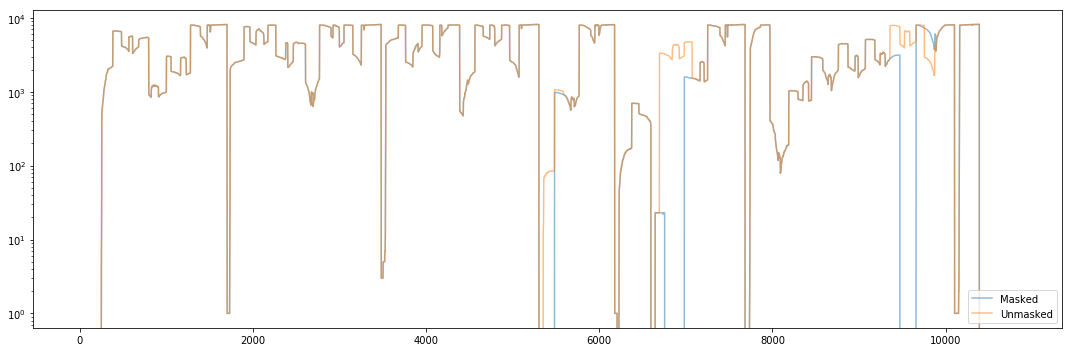

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

df_unmasked = pd.read_table("Z52.trimmed.sorted.depth", sep = "\t", names = ["Ref", "Pos", "depth_a", "depth_b"])
df_masked = pd.read_table("Z52.masked.sorted.depth", sep = "\t", names = ["Ref", "Pos", "depth_a", "depth_b"])

ax = df_masked["depth_a"].plot(logy=True, label = "Masked", figsize = (15,5), alpha = 0.5)
df_unmasked["depth_a"].plot(logy=True, ax = ax, label ="Unmasked", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

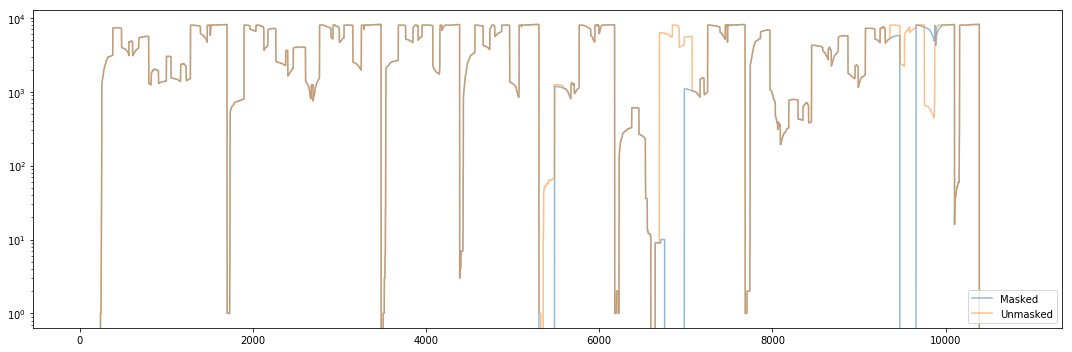

In [30]:
plt.clf()
ax = df_masked["depth_b"].plot(logy=True, label = "Masked", figsize = (15,5), alpha = 0.5)
df_unmasked["depth_b"].plot(logy=True, ax = ax, label ="Unmasked", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Let's now call iSNVs from the BAMS without reads from the masked amplicons.

In [31]:
%%bash
samtools mpileup -A -d 0 --reference db/PRV.fa -Q 0 Z52_a.masked.sorted.bam | ivar variants -p Z52_a -t 0.03
samtools mpileup -A -d 0 --reference db/PRV.fa -Q 0 Z52_b.masked.sorted.bam | ivar variants -p Z52_b -t 0.03

[mpileup] 1 samples in 1 input files
[mpileup] Max depth set to maximum value (2147483647)
[mpileup] 1 samples in 1 input files
[mpileup] Max depth set to maximum value (2147483647)


Let's now filter the iSNVs to get the ones called across both the replicates.

In [32]:
%%bash
ivar filtervariants -p Z52 Z52_a.tsv Z52_b.tsv

Let's now plot iSNVs from each replicate.

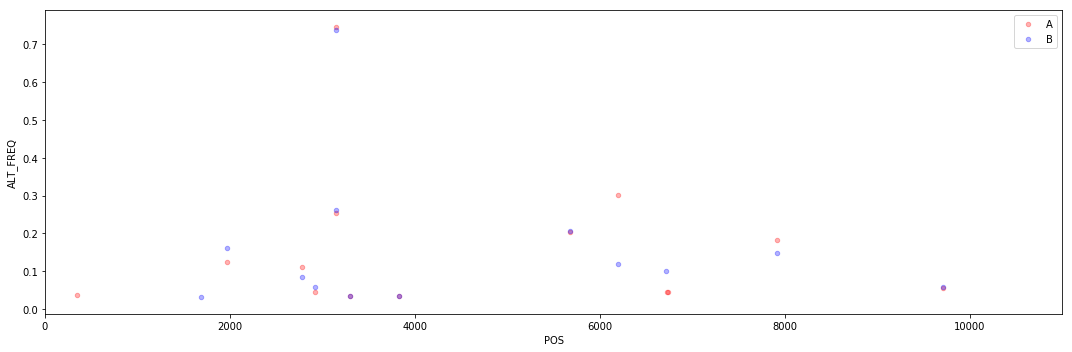

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

rep_a = pd.read_table("Z52_a.tsv", sep="\t")
rep_b = pd.read_table("Z52_b.tsv", sep="\t")

filtered = pd.read_table("Z52.tsv", sep="\t")

f, ax = plt.subplots(figsize=(15,5))
rep_a.plot(x="POS", y="ALT_FREQ", label="A", ax =ax, kind="scatter", color="red", alpha = 0.3)
rep_b.plot(x="POS", y="ALT_FREQ", label="B", ax = ax, kind="scatter", color="blue", alpha=0.3)
ax.set_xlim([0, 11000])
plt.legend()
plt.tight_layout()
plt.show()

Let's now see the variants that were removed after filtering.

<Figure size 432x288 with 0 Axes>

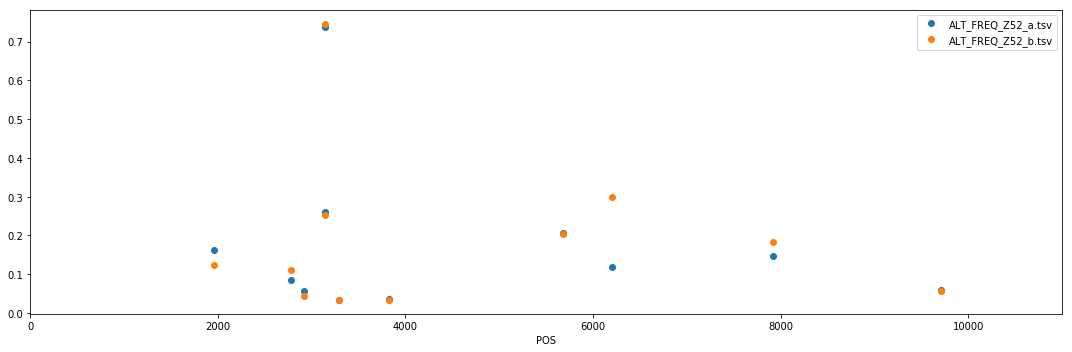

In [34]:
plt.clf()
ax = filtered.plot(x="POS", y=["ALT_FREQ_Z52_a.tsv", "ALT_FREQ_Z52_b.tsv"], marker='o', ls='', figsize=(15,5))
ax.set_xlim([0, 11000])
plt.legend()
plt.tight_layout()
plt.show()